In [151]:
from dolfinx import fem, mesh
from mpi4py import MPI
from petsc4py.PETSc import ScalarType 
from ufl import (TrialFunction, Measure, TestFunction, dx, ds, grad, inner)

import timeit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import ufl

In [152]:
class BoundaryCondition():
    def __init__(self, type, marker, values, V, ds):
        self._type = type
        if type == "Dirichlet":
            u_D = fem.Function(V)
            u_D.interpolate(values)
            facets = facet_tag.find(marker)
            dofs = fem.locate_dofs_topological(V, fdim, facets)
            self._bc = fem.dirichletbc(u_D, dofs)
        elif type == "Neumann":
                self._bc = inner(values, v) * ds(marker)
        elif type == "Robin":
            self._bc = values[0] * inner(u-values[1], v)* ds(marker)
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(type))
    @property
    def bc(self):
        return self._bc

    @property
    def type(self):
        return self._type

In [153]:
def generate_boundary_measure(domain, points):
    boundaries = [(1, lambda x: np.isclose(x[0], points[0])),
                  (2, lambda x: np.isclose(x[0], points[1]))]
    
    facet_indices, facet_markers = [], []
    fdim = domain.topology.dim - 1
    for (marker, locator) in boundaries:
        facets = mesh.locate_entities(domain, fdim, locator)
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

    ds = Measure("ds", domain=domain, subdomain_data=facet_tag)
    
    return ds

In [154]:
def validate_domains(domains):
    """
    domains = [(points: list[float, float], fluid: str), ...]
    """
    
    for i in range(len(domains)):
        if domains[i][0][1] < domains[i][0][0]:
            raise ValueError(f"Left boundary should be less then right for {domains[i][1]}")
    
    for i in range(1, len(domains)):
        if not np.isclose(domains[i-1][0][1], domains[i][0][0]):
            raise ValueError(f"{domains[i-1][1]} and {domains[i][1]} don't have the same right-left boundary")

In [183]:
def problem_setup(N: int,
                  domains, 
                  freq: float, 
                  pressure: float):
    """
    Performs problem configuration w.r.t. given parameters
    """
    
    validate_domains(domains)
    points = [domains[0][0][0], domains[-1][0][1]]
    
    # Mesh and function space definition
    domain = mesh.create_interval(MPI.COMM_WORLD, N, points)
    V = fem.FunctionSpace(domain, ("CG", 1))

    u = TrialFunction(V)
    v = TestFunction(V)
    
    # Definition of density and speed functions
    ro = fem.Function(V)
    c = fem.Function(V)
    
    cells = list()
    for i in range(len(domains)):
        a, b = domains[i][0]        
        cells.append(mesh.locate_entities(
             domain,
             domain.topology.dim, 
             lambda x: np.logical_and(np.greater_equal(x[0], a),
                                      np.less_equal(x[0], b))))
                             
    for i in range(len(domains)):
        cell = cells[i]
        fluid = domains[i][1]
        density, speed = fluids.loc[fluid, ['Density', 'Speed of sound']]
        
        ro.x.array[cell] = np.full_like(cell, density, dtype=ScalarType)
        c.x.array[cell] = np.full_like(cell, speed, dtype=ScalarType)
        
    omega = freq * 2 * np.pi
        
    # Construction of bilinear form and linear functional
    aa = ro * c**2 * inner(grad(u), grad(v)) * dx
    mm = ro * inner(u, v) * dx

    F = aa - omega**2 * mm
    
    ds = generate_boundary_measure(domain, points)
    
    boundary_conditions = [BoundaryCondition("Neumann", 1, ScalarType(0.0), V, ds), 
                           BoundaryCondition("Neumann", 2, ScalarType(1.0), V, ds)]
    
    bcs = []
    for condition in boundary_conditions:
        if condition.type == "Dirichlet":
            bcs.append(condition.bc)
        else:
            F += condition.bc
    
    # Left = ufl.lhs(F)
    Right = ufl.rhs(F)
    
    return {
        'Params': (N, points, domains, omega, pressure),
        'FunctionSpace': (domain, V, u, v),
        'Problem': (Left, Right, bc)
    }

#### Available fluids

In [184]:
fluids = pd.read_csv('../data/physical_properties.csv', sep=';', index_col='Fluid')
fluids

,Density,Speed of sound,Viscosity
Fluid,,,
Water,1000,1500,0.000894
Fuel oil,890,1360,2.022000
Oil,760,1470,0.000500


In [185]:
config = problem_setup(N=100, 
                       domains=[([0.0, 5.0], 'Fuel oil'),
                                (([5.0, 10.0]), 'Oil')],
                       freq=1000,
                       pressure=1.0)

N, points, domains, omega, pressure = config['Params']
domain, V, u, v = config['FunctionSpace']
Left, Right, bc = config['Problem']

Found different Arguments with same number and part.
Did you combine test or trial functions from different spaces?
The Arguments found are:
  v_0
  v_1
  v_0


ERROR:UFL:Found different Arguments with same number and part.
Did you combine test or trial functions from different spaces?
The Arguments found are:
  v_0
  v_1
  v_0


UFLException: Found different Arguments with same number and part.
Did you combine test or trial functions from different spaces?
The Arguments found are:
  v_0
  v_1
  v_0

In [170]:
problem = fem.petsc.LinearProblem(Left, Right, bcs=[bc])
uh = problem.solve()

In [150]:
vec = fem.petsc.assemble_vector(fem.form(Right))

In [111]:
vec.array

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

## Results

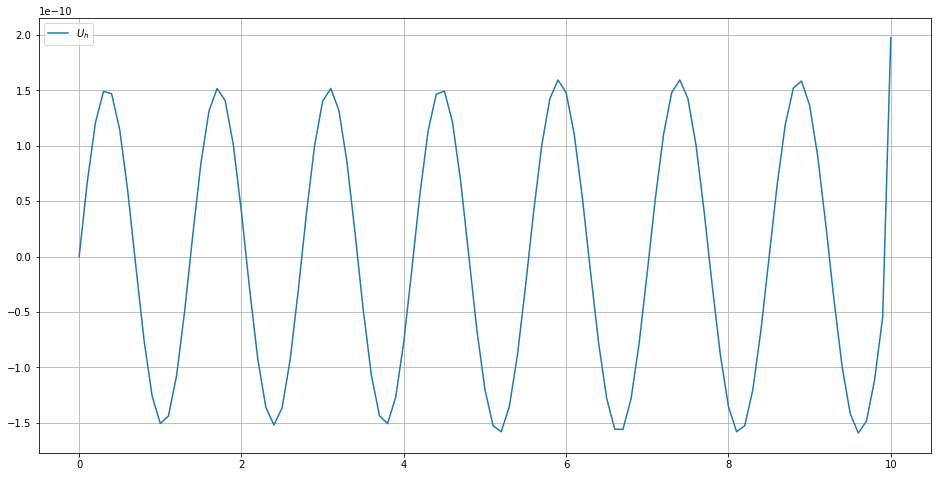

In [97]:
fig, ax = plt.subplots(figsize=(16,8))
# fig.suptitle(f'1-d Wave propagation in {fluid}', y=0.92, fontsize=16)

xs1 = np.linspace(points[0], points[1], uh.vector.array.size)
# xs2 = np.linspace(points[0], points[1], u_ex.vector.array.size)

ax.plot(xs1, uh.vector.array, label=r'$ U_h $')
# ax.plot(xs2, u_ex.vector.array, label=r'$ U $')

ax.legend()
ax.grid()

In [89]:
def L2_norm(fun):
    comm = uh.function_space.mesh.comm
    error = fem.form(fun**2 * dx)
    norm = np.sqrt(comm.allreduce(fem.assemble_scalar(error), MPI.SUM))
    
    if comm.rank == 0:
        return norm

In [90]:
def L2_error(uh, u_ex):
    comm = uh.function_space.mesh.comm
    error = fem.form((uh - u_ex)**2 * dx)
    E = np.sqrt(comm.allreduce(fem.assemble_scalar(error), MPI.SUM))
    
    if comm.rank == 0:
        return E

In [91]:
print(f"L2 Error: {L2_error(uh, u_ex):.2e}")

NameError: name 'u_ex' is not defined

## Convergence

In [11]:
def calc_convergence(rounds: int = 5):
    """
    Convergence calculation
    """
    
    results = list()
    for i in range(rounds):
        config = problem_setup(N=10 * 2**i, 
                           points=[0.0, 10.0],
                           fluid='Water',
                           freq=160,
                           pressure=1.0)

        fluid, points, speed, density, omega, pressure = config['Params']
        domain, V, u, v = config['FunctionSpace']
        Left, Right, bc = config['Problem']
        
        problem = fem.petsc.LinearProblem(Left, Right, bcs=[bc])
        
        start = timeit.default_timer()
        uh = problem.solve()
        stop = timeit.default_timer()
        
        u_ex = fem.Function(V)
        u_ex.interpolate(u_exact)
        
        norm_l2_uh = L2_norm(uh)
        error = L2_error(uh, u_ex)
        
        results.append([10 * 2**i, norm_l2_uh, error, np.nan, stop - start])
                  
        if len(results) > 2:
            results[-1][3] = np.log2((results[-3][2] - results[-2][2])/(results[-2][2] - results[-1][2]))
        
    return results

In [12]:
cdata = calc_convergence(14)
cdf = pd.DataFrame(cdata, columns=['N', '||u_h||', 'error', 'k', 'time']).set_index('N')
cdf

,||u_h||,error,k,time
N,,,,
10,1.492846e-09,1.179467e-10,NaN,0.000482
20,1.552151e-09,3.284039e-11,NaN,0.000347
40,1.570885e-09,8.460551e-12,1.803577,0.000406
80,1.575851e-09,2.131528e-12,1.945634,0.000349
160,1.577110e-09,5.339185e-13,1.986068,0.000389
320,1.577426e-09,1.335446e-13,1.996495,0.000631
640,1.577506e-09,3.339021e-14,1.999122,0.000539
1280,1.577525e-09,8.347805e-15,1.999781,0.000827
2560,1.577530e-09,2.087136e-15,1.999984,0.001583
